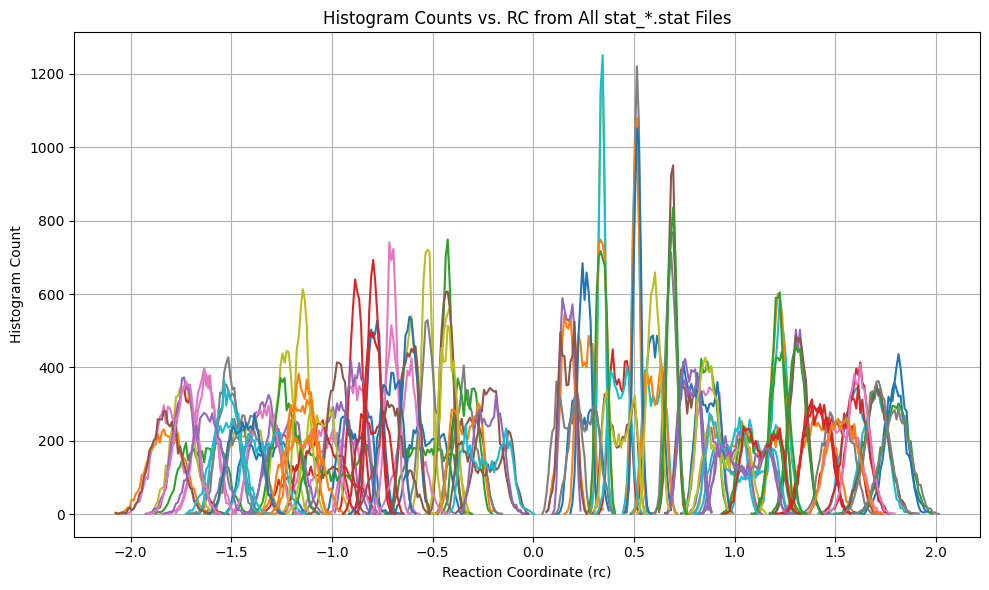

In [ ]:
# REACTION COORDINATE HISTOGRAMS PLOTTING SCRIPT

import os
import matplotlib.pyplot as plt

# Set your target directory here # dont forget replace username
directory = "/jet/home/arattuth/10th_workshop_QM_MM_AIMD/04_thursday/knam_session03_thu_2pm/04_folate_dhfr_charmm_mods/cnt2to5_20ps_stat_files"  # <-- Change this to your actual path

# Initialize a plot
plt.figure(figsize=(10, 6))

# Iterate through files in the directory
for filename in os.listdir(directory):
    if filename.startswith("stat_") and filename.endswith(".stat"):
        filepath = os.path.join(directory, filename)
        try:
            # Load the data
            data = []
            with open(filepath, 'r') as f:
                for line in f:
                    if line.strip() and not line.startswith('#'):
                        parts = line.strip().split()
                        if len(parts) >= 3:
                            rc = float(parts[0])
                            hist = float(parts[2])
                            data.append((rc, hist))

            if data:
                data.sort()  # Sort by rc
                rc_vals, hist_vals = zip(*data)
                plt.plot(rc_vals, hist_vals, label=filename)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

# Finalize the plot
plt.xlabel("Reaction Coordinate (rc)")
plt.ylabel("Histogram Count")
plt.title("Histogram Counts vs. RC from All stat_*.stat Files")
plt.grid(True)
plt.tight_layout()
plt.show()


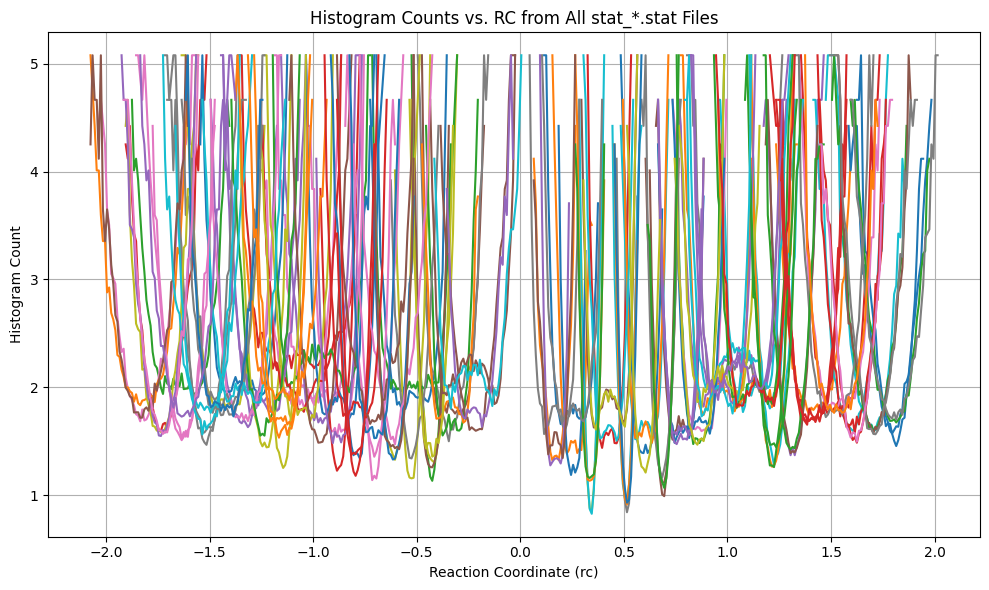

In [ ]:
# REACTION COORDINATE UNBIASED ENERGY PLOTTING SCRIPT

import os
import matplotlib.pyplot as plt

# Set your target directory here # dont forget replace username
directory = "/jet/home/arattuth/10th_workshop_QM_MM_AIMD/04_thursday/knam_session03_thu_2pm/04_folate_dhfr_charmm_mods/cnt2to5_20ps_stat_files"  # <-- Change this to your actual path

# Initialize a plot
plt.figure(figsize=(10, 6))

# Iterate through files in the directory
for filename in os.listdir(directory):
    if filename.startswith("stat_") and filename.endswith(".stat"):
        filepath = os.path.join(directory, filename)
        try:
            # Load the data
            data = []
            with open(filepath, 'r') as f:
                for line in f:
                    if line.strip() and not line.startswith('#'):
                        parts = line.strip().split()
                        if len(parts) >= 3:
                            rc = float(parts[0])
                            hist = float(parts[3])
                            data.append((rc, hist))

            if data:
                data.sort()  # Sort by rc
                rc_vals, hist_vals = zip(*data)
                plt.plot(rc_vals, hist_vals, label=filename)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

# Finalize the plot
plt.xlabel("Reaction Coordinate (rc)")
plt.ylabel("Histogram Count")
plt.title("Histogram Counts vs. RC from All stat_*.stat Files")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# USE WHAM TO PLOT PMF
import os
import re
import subprocess
import matplotlib.pyplot as plt

# Settings
wham_exe = "/ocean/projects/see220002p/shared/10th/wham/wham/install/bin/wham"  # Change to your WHAM path
input_dir = "/jet/home/arattuth/10th_workshop_QM_MM_AIMD/04_thursday/knam_session03_thu_2pm/04_folate_dhfr_charmm_mods/cnt2to5_20ps_cv_files"
output_metadata_file = f"{input_dir}/metadata.dat"
temp = 300.0
tolerance = 1e-5
wham_output_file = f"{input_dir}/result.dat"

# Regex to match files
filename_pattern = re.compile(
    r"rstcv_win_(\d+)_cnt_(\d+)_rc_([-+]?\d*\.?\d+)_k_([-+]?\d*\.?\d+)_([A-Za-z]+)\.cv"
)

rc_list = []

# Generate metadata.dat with each file
with open(output_metadata_file, "w") as meta_out:
    for filename in os.listdir(input_dir):
        match = filename_pattern.match(filename)
        if not match:
            continue
        win, cnt, rc, k, package = match.groups()
        path = os.path.join(input_dir, filename)
        rc = float(rc)
        k = float(k) * 2  # WHAM expects 2*k for Grossfield format coming from amber and charmm
        rc_list.append(rc)
        meta_out.write(f"{path} {rc} {k}\n")

# Sort and determine histogram range
rc_list = sorted(set(rc_list))
if len(rc_list) < 2:
    raise ValueError("Not enough distinct RC values to compute WHAM histogram.")
delta = min(j - i for i, j in zip(rc_list[:-1], rc_list[1:]))
hist_min = rc_list[0] - delta * 1.5
hist_max = rc_list[-1] + delta * 1.5
num_bins = len(rc_list) + 2

# Run WHAM
wham_cmd = [
    wham_exe,
    str(hist_min),
    str(hist_max),
    str(num_bins),
    str(tolerance),
    str(temp),
    str(0),  # No bootstrap
    output_metadata_file,
    wham_output_file
]

print("Running WHAM...")
result = subprocess.run(wham_cmd, capture_output=True, text=True)

if result.returncode == 0:
    print("WHAM finished successfully.")
    print(f"Output written to {wham_output_file}")
else:
    print("WHAM failed:")
    print(result.stderr)
    exit(1)

# Plot PMF
try:
    x, y = [], []
    with open(wham_output_file) as f:
        for line in f:
            if line.strip() and not line.startswith('#'):
                parts = line.strip().split()
                if len(parts) >= 2:
                    x.append(float(parts[0]))
                    y.append(float(parts[1]))

    plt.figure(figsize=(6, 4))
    plt.plot(x, y, label='PMF', color='blue')
    plt.xlabel('Reaction Coordinate')
    plt.ylabel('Free Energy (kcal/mol)')
    plt.title('Potential of Mean Force (WHAM)')
    plt.tight_layout()
    plt.savefig('wham_output.png', dpi=300)
    plt.close()
    print("Plot saved as wham_output.png")

except Exception as e:
    print(f"Could not generate plot: {e}")


In [ ]:
# PLOT TWO PMF CURVES FROM TWO WHAM OUTPUTS ON SAME FIGURE
import matplotlib.pyplot as plt

# === Set your file paths here ===
file1 = "/path/to/first_wham_output.txt"   # Replace with actual path
file2 = "/path/to/second_wham_output.txt"  # Replace with actual path

def read_pmf(filepath):
    x, y = [], []
    with open(filepath) as f:
        for line in f:
            if line.strip() and not line.startswith('#'):
                parts = line.strip().split()
                if len(parts) >= 2:
                    x.append(float(parts[0]))
                    y.append(float(parts[1]))
    return x, y

# Read both files
x1, y1 = read_pmf(file1)
x2, y2 = read_pmf(file2)

# Plot both
plt.figure(figsize=(6, 4))
plt.plot(x1, y1, label='PMF 1', color='blue')
plt.plot(x2, y2, label='PMF 2', color='red')
plt.xlabel('Reaction Coordinate')
plt.ylabel('Free Energy (kcal/mol)')
plt.title('Potential of Mean Force (WHAM)')
plt.legend()
plt.tight_layout()
#plt.savefig('wham_output_combined.png', dpi=300)
plt.close()

#print("Plot saved as wham_output_combined.png")
